In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Function to evaluate model
# Function to evaluate model
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, predictions, zero_division=1))  # Set zero_division to 1
    print("-" * 60)  # Separator


nba_data = pd.read_csv('nba_final_elo.CSV')

# Splitting the dataset
X = nba_data.drop('Result',axis=1)
y = nba_data['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1113)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logreg = LogisticRegression(C=0.001, random_state=1113)
rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=20, random_state=1113)
knn = KNeighborsClassifier(n_neighbors=20)
svm = SVC(C=0.01, probability=True, random_state=1113)
gnb = GaussianNB(var_smoothing=1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=10, max_depth=2, min_child_weight=10, gamma=1, random_state=1113)

# Fit models
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
gnb.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Evaluate each model
evaluate_model(logreg, X_test, y_test, "Logistic Regression")
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(knn, X_test, y_test, "K-Nearest Neighbors")
evaluate_model(svm, X_test, y_test, "Support Vector Machine")
evaluate_model(gnb, X_test, y_test, "Gaussian Naive Bayes")
evaluate_model(xgb, X_test, y_test, "XGBoost")


c:\Users\dongm\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.36      0.48       272
           1       0.62      0.88      0.73       328

    accuracy                           0.65       600
   macro avg       0.67      0.62      0.60       600
weighted avg       0.67      0.65      0.62       600

------------------------------------------------------------
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       272
           1       0.79      0.83      0.81       328

    accuracy                           0.79       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.79      0.78       600

------------------------------------------------------------
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.79      0.78 

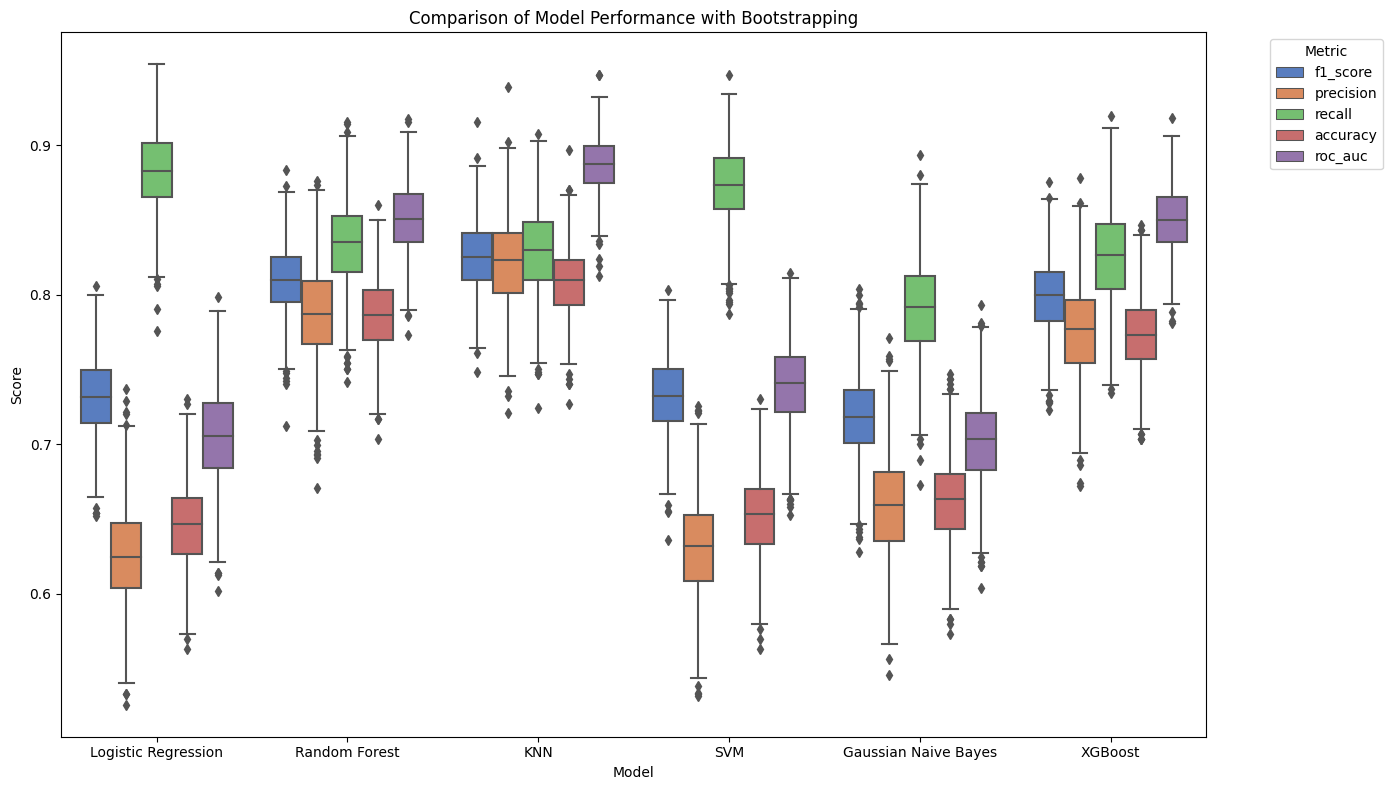

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

# Assuming you have a list of your models and their names
models = [logreg, rf, knn, svm, gnb, xgb]
model_names = ["Logistic Regression", "Random Forest", "KNN", "SVM", "Gaussian Naive Bayes", "XGBoost"]

# Bootstrapping and storing results
n_iterations = 1000  # Number of bootstrap samples
n_size = int(len(X_test) * 0.50)  # 50% sample size

# Data structure to store the bootstrap results
bootstrap_results = []

# Perform bootstrapping
for model, name in zip(models, model_names):
    # Temporary list to store the metrics for each bootstrap iteration
    temp_metrics = {'f1_score': [], 'precision': [], 'recall': [], 'accuracy': [], 'roc_auc': []}
    for i in range(n_iterations):
        # Prepare bootstrap sample
        boot_X_test, boot_y_test = resample(X_test, y_test, n_samples=n_size)
        predictions = model.predict(boot_X_test)
        proba = model.predict_proba(boot_X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate metrics
        temp_metrics['f1_score'].append(f1_score(boot_y_test, predictions))
        temp_metrics['precision'].append(precision_score(boot_y_test, predictions))
        temp_metrics['recall'].append(recall_score(boot_y_test, predictions))
        temp_metrics['accuracy'].append(accuracy_score(boot_y_test, predictions))
        if proba is not None:
            temp_metrics['roc_auc'].append(roc_auc_score(boot_y_test, proba))

    # Append the metrics for this model to the bootstrap_results list
    for metric, scores in temp_metrics.items():
        for score in scores:
            bootstrap_results.append({'model': name, 'metric': metric, 'score': score})

# Convert the bootstrap_results to a DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results)

# Visualization with boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='model', y='score', hue='metric', data=bootstrap_df, palette="muted")
plt.title('Comparison of Model Performance with Bootstrapping')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
